# Wasserstein measure

In [26]:
import pickle as pk
import sys
import time
from pathlib import Path

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch
from mpl_toolkits.mplot3d import Axes3D
from numpy import arccos, array, clip
from src.ri_distances.eval_predictor import (
    display_predictor_metrics_vs_pnt_cloud_size, evaluate_predictor, plot_MSE,
    plot_time)
from src.ri_distances.pnt_cloud_generation import (generate_target,
                                                   get_gaussian_point_cloud,
                                                   get_spiral)
from src.ri_distances.SGW.sgw import get_data, get_P, get_rot
from src.ri_distances.SGW.sgw_pytorch import sgw_gpu_np
from src.ri_distances.rotation_predictor import MSE
from tqdm import tqdm, trange

plt.style.use('ggplot')

torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import pickle as pk
from dataclasses import dataclass

import pandas as pd
from se3_transformer_pytorch.irr_repr import rot
from src.ri_distances.eval_data_param import (DataParam,
                                              display_metric_vs_time_results,
                                              load_most_recent)
from src.ri_distances.icp.icp import IcpPredictor
from src.ri_distances.pnt_cloud_generation import (generate_permutation_matrix,
                                                   generate_rotation_matrix)
from src.ri_distances.SGW.risgw import (RisgwPredictor, risgw_gpu,
                                        train_and_get_RISGW_affine_map)
from src.ri_distances.SGW.sgw_pytorch import sgw_gpu
from src.se3.visualization import viz_point_cloud, viz_point_cloud_2d

import wandb


## Point cloud Visualization

We visualize the parameters for the longer runs in .py scripts here

In [141]:
# src_pnt_cloud = get_spiral(N_pts=40)
src_pnt_cloud = get_gaussian_point_cloud(N_pts=40)


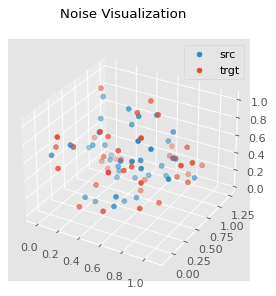

In [142]:

Q,P,trgt_pnt_cloud = generate_target(src_pnt_cloud,theta=0,noise_factor=0.12)
fig = viz_point_cloud([(src_pnt_cloud,'src'),
                 (trgt_pnt_cloud,'trgt'),
                     ])
fig.suptitle('Noise Visualization')
fig

## Point Cloud alignment

<div class="alert alert-block alert-success">
The goal consists in realigning a gaussian point cloud with its rotated/permuted version
</div>

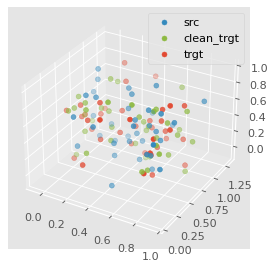

In [22]:
# src_pnt_cloud = get_spiral(N_pts=40)
src_pnt_cloud = get_gaussian_point_cloud(N_pts=40)
Q,P,trgt_pnt_cloud = generate_target(src_pnt_cloud,noise_factor=0.08)
clean_trgt_pts = P @ src_pnt_cloud @ Q
viz_point_cloud([(src_pnt_cloud,'src'),
                 (clean_trgt_pts,'clean_trgt'),
                 (trgt_pnt_cloud,'trgt'),
                     ])

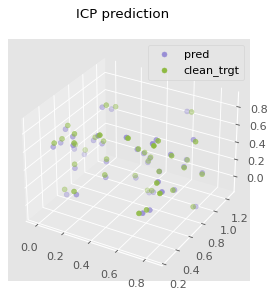

In [23]:
predictor = IcpPredictor(max_iter=100,N_rots=100) 
pred_pnts = predictor.predict(src_pnt_cloud,trgt_pnt_cloud)
fig = viz_point_cloud([(pred_pnts,'pred'),
                 (clean_trgt_pts,'clean_trgt'),
                     ])
fig.suptitle("ICP prediction")
fig

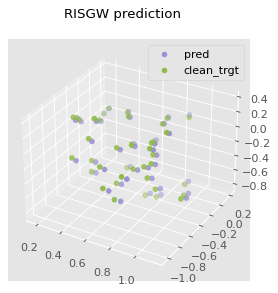

In [88]:

predictor = RisgwPredictor(max_iter=1200)
pred_pnts = predictor.predict(src_pnt_cloud,trgt_pnt_cloud)
fig = viz_point_cloud([(pred_pnts,'pred'),
                 (clean_trgt_pts,'clean_trgt'),
                     ])
fig.suptitle("RISGW prediction")
fig

We check whether the inferred permutation is consistent by plotting the first N points

In [90]:
# viz_point_cloud([(pred_pnts[:50],'pred'),
#                     (trgt_pnt_cloud[:50],'trgt')
#                      ])

## RISGW

### 2d

We create the source and target point clouds

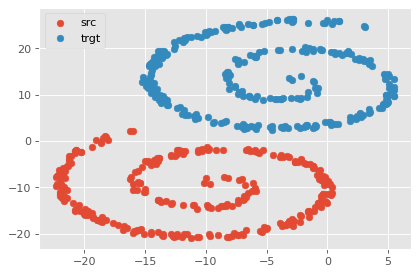

In [14]:
n_samples=300
theta=np.pi/2

Xs,_ = get_data(n_samples,theta,scale=1,transla=10)
Q = get_rot(1)
Xt = Xs @ Q + (10,10)
viz_point_cloud_2d([(Xs,'src'),(Xt,'trgt')])

In [15]:
P2d = get_P(2,500)
P2d = torch.from_numpy(P2d).to(torch.float32)
xs=torch.from_numpy(Xs).to(torch.float32)
xt=torch.from_numpy(Xt).to(torch.float32)
aff_map_2d = train_and_get_RISGW_affine_map(xs,xt,P=P2d,max_iter=100)
xpred = aff_map_2d(xs)
Xpred = xpred.detach().numpy()

RISGW affine map optimization: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


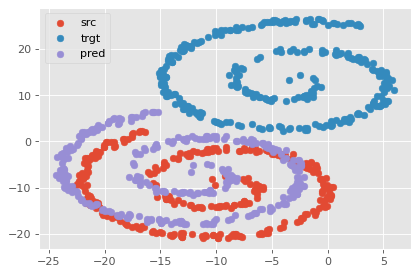

In [13]:
viz_point_cloud_2d([(Xs,'src'),
                    (Xt,'trgt'),
                    (Xpred,'pred')])

## Testing performances

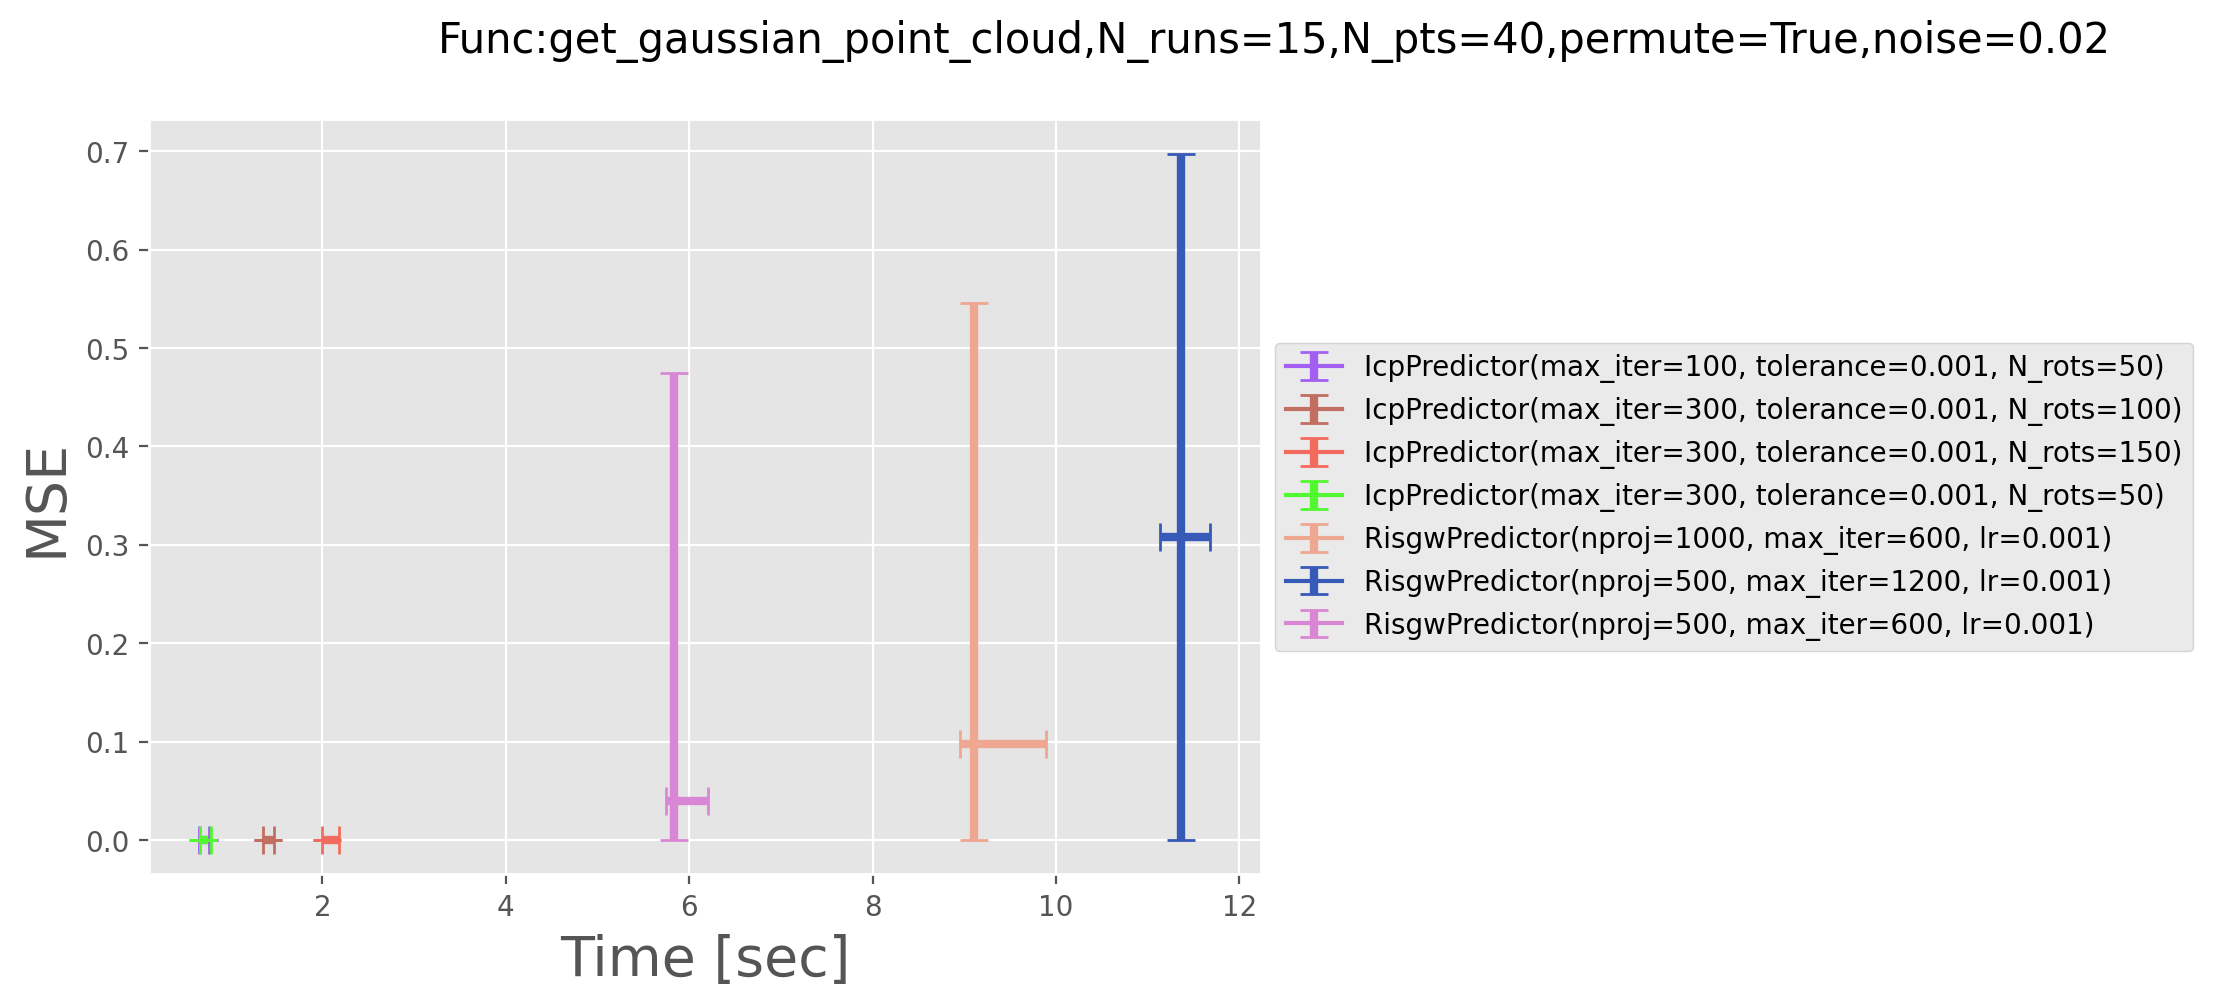

In [23]:
results = load_most_recent(Path("../models/"))
fig,ax = plt.subplots(1,dpi=100,figsize=(15,5))
display_metric_vs_time_results(results,fig,ax)

## Visualizing the performances


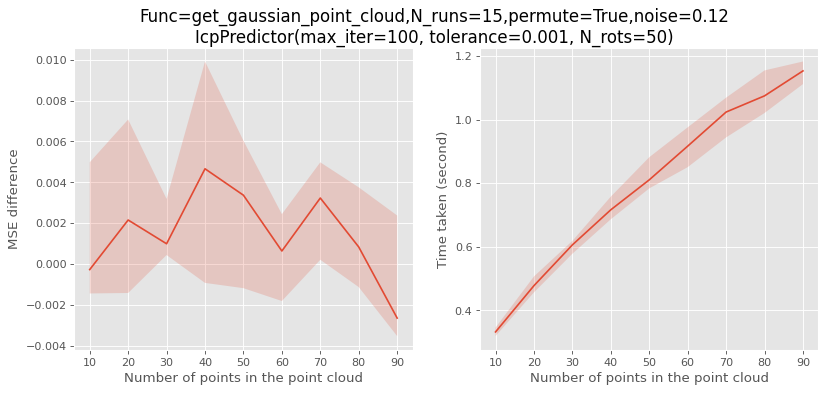

In [10]:
results = load_most_recent(Path("../models/"))
display_predictor_metrics_vs_pnt_cloud_size(results)